In [1]:
#import all libraries
import pandas as pd
import numpy as np
import pvlib
import datetime
import math
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import warnings

#import all required libraries from pvlib
from pvlib import pvsystem
from pvlib import location
from pvlib import modelchain
from pvlib.pvsystem import PVSystem, FixedMount
from pvlib.location import Location
from pvlib.modelchain import ModelChain

from pvlib.bifacial.pvfactors import pvfactors_timeseries
from pvlib.temperature import TEMPERATURE_MODEL_PARAMETERS as PARAMS

#import all data analysis tools
from numpy import median
from datetime import datetime
from pandas.plotting import register_matplotlib_converters
from matplotlib.pyplot import figure

register_matplotlib_converters()


#setting plotting preferences
mpl.rcParams['font.size']=12
mpl.rcParams['lines.linewidth']=0.75
mpl.rcParams['xtick.labelsize']=10
#mpl.rcParams['font.weight']='bold'
mpl.rcParams['axes.titlesize']=22
sns.set(rc={'figure.figsize':(12,7)})
sns.set_style('whitegrid')
sns.set_context("poster", font_scale=1) 

# supressing shapely warnings that occur on import of pvfactors
warnings.filterwarnings(action='ignore', module='pvfactors')

In [2]:
#location data
tz = 'Etc/GMT+6'#works better with +GMT
lat, lon = 30.2, -92.02
alt = 13 #elevation in meters
loc = location.Location(latitude=30.2, longitude= -92.02, tz=tz,altitude=alt, name='Lafayette,LA') #loc=site location

#Import weatherdata
#df=pd.read_csv('Desktop/MET_FiveMin_Python.csv',index_col=0)
df=pd.read_csv('Desktop/Bifacial_FiveSec_SPD.csv',index_col=0)
#Apply filtering to data set, 
df = pd.DataFrame(data=df) #Convert to dataframe
df.index = pd.to_datetime(df.index) #convert to datetime
df=df[(df.index.hour>=6)&(df.index.hour<=18)].copy()#removing night time values
df=df.replace(0, np.nan) #replace all 0 to nan to properly get the avvg in an hour
df_minute=(df.resample('5Min').mean())
df1 =df_minute             
#df1=df['2023-02-07 06:00':'2023-03-21 18:00'] # # restrict data to represent only this range
df1

C:\Users\Admin\AppData\Local\Temp\ipykernel_32628\675555547.py:9: DtypeWarning: Columns (31,33) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv('Desktop/Bifacial_FiveSec_SPD.csv',index_col=0)


,RefCell02_Irr,RefCell02_CellTemp,RefCell02_BackOfMTemp,RefCell03_Irr,RefCell03_CellTemp,RefCell03_BackOfMTemp,RefCell04_Irr,RefCell04_CellTemp,RefCell04_BackOfMTemp,RefCell05_Irr,...,Declination,SunRise,SunSet,Diffused_Avg,DNI_Avg,Global_Avg,POA_Avg,WS_ms_Avg,AirTC_Avg,BP_mbar_Avg
TIMESTAMP,,,,,,,,,,,,,,,,,,,,,
2023-02-06 11:40:00,750.566667,38.633333,21.500000,79.083333,25.666667,25.116667,513.000000,33.483333,22.200000,186.700000,...,-0.271,6.989,17.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-02-06 11:45:00,751.370000,38.833333,21.586667,79.106667,25.726667,25.160000,519.683333,33.970000,22.306667,184.880000,...,-0.271,6.989,17.75,97.4,900.0,749.7,995.0,3.304,21.68,1025.426
2023-02-06 11:50:00,756.505882,38.286555,21.645378,79.901681,25.757143,25.241176,535.736134,34.284874,22.355462,183.394118,...,-0.271,6.989,17.75,96.1,905.0,754.4,1002.0,3.168,21.68,1025.361
2023-02-06 11:55:00,755.522727,37.131111,20.377778,80.154545,24.464444,23.822222,547.613636,33.277778,20.997778,180.263636,...,-0.271,6.989,17.75,97.1,908.0,760.5,1010.0,3.395,21.72,1025.289
2023-02-06 12:00:00,756.200000,38.270000,21.463333,80.430000,25.516667,24.840000,559.080000,34.516667,21.943333,177.443333,...,-0.271,6.989,17.75,95.9,905.0,758.8,1007.0,3.058,21.63,1025.112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-23 18:35:00,25.766667,26.223333,25.895000,24.825000,27.323333,26.978333,74.095000,27.555000,26.611667,14.291667,...,0.021,7.195,19.29,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-03-23 18:40:00,28.248333,26.000000,25.616667,24.836667,26.901667,26.388333,84.955000,27.085000,25.985000,15.381667,...,0.021,7.195,19.29,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-03-23 18:45:00,25.926667,26.030000,25.616667,22.671667,26.800000,26.138333,89.258333,27.416667,26.080000,13.913333,...,0.021,7.195,19.29,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
#import power data from inverter
pdf = pd.read_excel('Desktop/PythonData/117765_Data.xlsx',index_col=0)
pdf = pd.DataFrame(data=pdf) #Convert to dataframe
pdf.index = pd.to_datetime(pdf.index) #convert to datetime
pdf=pdf[(pdf.index.hour>=6)&(pdf.index.hour<=18)].copy()#removing night time values
pdf = pdf.replace(0, np.nan) #replace all 0 to nan to properly get the avvg in an hour

pdf_minute= (pdf.resample('5Min').mean()) #resample date to hourly with the mean
#limit time
pdf1=pdf_minute['2023-02-06 11:40':'2023-03-21 18:00'] #match with weather data
pdf1

,1(DC-P)/W,1(DC-V)/V,1(DC-I)/A,2(DC-P)/W,2(DC-V)/V,2(DC-I)/A,3(DC-P)/W,3(DC-V)/V,3(DC-I)/A,4(DC-P)/W,4(DC-V)/V,4(DC-I)/A,(AC-V)/V,AC-F/Hz,T/°C,INVERTER-P/W
Time,,,,,,,,,,,,,,,,
2023-02-06 11:40:00,272.0,37.6,7.2,270.0,37.6,7.1,285.0,37.6,7.5,297.0,37.9,7.8,255.0,59.9,40.0,1124.0
2023-02-06 11:45:00,274.0,37.4,7.3,272.0,37.2,7.3,287.0,37.8,7.6,299.0,38.0,7.8,256.0,59.9,40.0,1132.0
2023-02-06 11:50:00,274.0,37.7,7.3,272.0,37.5,7.2,288.0,37.8,7.6,299.0,38.0,7.9,255.0,59.9,40.0,1133.0
2023-02-06 11:55:00,276.0,38.4,7.0,274.0,37.4,7.2,290.0,37.9,7.6,301.0,38.1,7.8,256.0,60.0,40.0,1141.0
2023-02-06 12:00:00,276.0,37.4,7.3,274.0,37.5,7.3,289.0,37.9,7.6,301.0,38.1,7.8,256.0,60.0,40.0,1140.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-21 17:40:00,62.0,38.6,1.1,65.0,37.5,1.2,83.0,39.0,1.5,88.0,38.8,1.6,246.0,59.9,28.0,298.0
2023-03-21 17:45:00,65.0,38.4,1.6,67.0,37.8,1.7,87.0,39.3,2.1,92.0,39.3,2.3,248.0,60.0,28.0,311.0
2023-03-21 17:50:00,60.0,38.2,1.4,62.0,37.7,1.5,82.0,39.3,2.0,87.0,39.3,2.1,248.0,59.9,28.0,291.0


In [4]:
df1= pd.merge(df1, pdf1, left_index=True, right_index=True)
#df1
df1=df1[(df1.index.hour>=6)&(df1.index.hour<=18)].copy()#removing night time values
df1

,RefCell02_Irr,RefCell02_CellTemp,RefCell02_BackOfMTemp,RefCell03_Irr,RefCell03_CellTemp,RefCell03_BackOfMTemp,RefCell04_Irr,RefCell04_CellTemp,RefCell04_BackOfMTemp,RefCell05_Irr,...,3(DC-P)/W,3(DC-V)/V,3(DC-I)/A,4(DC-P)/W,4(DC-V)/V,4(DC-I)/A,(AC-V)/V,AC-F/Hz,T/°C,INVERTER-P/W
2023-02-06 11:40:00,750.566667,38.633333,21.500000,79.083333,25.666667,25.116667,513.000000,33.483333,22.200000,186.700000,...,285.0,37.6,7.5,297.0,37.9,7.8,255.0,59.9,40.0,1124.0
2023-02-06 11:45:00,751.370000,38.833333,21.586667,79.106667,25.726667,25.160000,519.683333,33.970000,22.306667,184.880000,...,287.0,37.8,7.6,299.0,38.0,7.8,256.0,59.9,40.0,1132.0
2023-02-06 11:50:00,756.505882,38.286555,21.645378,79.901681,25.757143,25.241176,535.736134,34.284874,22.355462,183.394118,...,288.0,37.8,7.6,299.0,38.0,7.9,255.0,59.9,40.0,1133.0
2023-02-06 11:55:00,755.522727,37.131111,20.377778,80.154545,24.464444,23.822222,547.613636,33.277778,20.997778,180.263636,...,290.0,37.9,7.6,301.0,38.1,7.8,256.0,60.0,40.0,1141.0
2023-02-06 12:00:00,756.200000,38.270000,21.463333,80.430000,25.516667,24.840000,559.080000,34.516667,21.943333,177.443333,...,289.0,37.9,7.6,301.0,38.1,7.8,256.0,60.0,40.0,1140.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-21 17:40:00,182.318333,25.755000,24.285000,64.778333,24.823333,27.413333,576.225000,33.675000,29.176667,65.431667,...,83.0,39.0,1.5,88.0,38.8,1.6,246.0,59.9,28.0,298.0
2023-03-21 17:45:00,179.240000,25.935000,24.471667,67.296667,24.968333,27.198333,605.440000,34.765000,29.976667,64.873333,...,87.0,39.3,2.1,92.0,39.3,2.3,248.0,60.0,28.0,311.0
2023-03-21 17:50:00,162.336667,25.480000,24.106667,65.625000,24.818333,26.800000,577.635000,34.643333,29.461667,59.440000,...,82.0,39.3,2.0,87.0,39.3,2.1,248.0,59.9,28.0,291.0
2023-03-21 17:55:00,147.926667,24.956667,23.575000,64.286667,24.500000,26.158333,555.751667,33.916667,28.551667,55.250000,...,75.0,39.4,1.8,80.0,39.4,1.9,247.0,59.9,27.0,265.0


In [5]:
# set ground coverage ratio 
# set axis_azimuth, albedo, pvrow width and height, and use
# the pvfactors engine for both front and rear-side absorbed irradiance

pvrow_height =1.52  #Measured height of the pv rows, measured at their center / torque tube) (m) 
pvrow_width =1.002 #Measured width of the pv rows in the considered 2D plane (m) 
pitch = 3.33 #measured from 118488 to 117765
gcr =  0.3 #pvrow_width /pitch #formular gcr
albedo = 0.2 #assumed albedo for a normal ground surface
bifaciality = 0.63 #measured during the iv-curve trace test #Prear at STC /Pfront at STC

# load temperature parameters and module/inverter specifications
temperature_model_parameters = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_polymer']

# load module/inverter specifications from cec database
#cec_modules = pvlib.pvsystem.retrieve_sam('CECMod',path='Documents\CEC_Modules')
#manually input cec_modules
cec_modules=pd.read_csv('Documents\CEC_Modules.csv',index_col=0)
cec_df = pd.DataFrame(cec_modules)
cec_modules1 = cec_df.transpose()
cec_module = cec_modules1['Prism Solar Technologies Inc. BHC72-390']

cec_inverters = pvsystem.retrieve_sam('cecinverter')
cec_inverter = cec_inverters['Altenergy_Power_System_Inc___QS1__240V_']


In [6]:
# dc arrays
array = pvsystem.Array(mount=FixedMount,
                       module_parameters=cec_module,
                       temperature_model_parameters=temperature_model_parameters)

# create system object
system = pvsystem.PVSystem(arrays=[array],
                           inverter_parameters=cec_inverter)



# get rear and front side irradiance from pvfactors transposition engine
irrad = pvfactors_timeseries(
    solar_azimuth=df1['SolarAzimuth'],
    solar_zenith=df1['SolarZenith'],
    surface_azimuth=180,  # south-facing array
    surface_tilt=90,
    axis_azimuth=90,  # 90 degrees off from surface_azimuth.  270 is ok too For fixed tilt
    timestamps=df1.index,
    dni=df1['DNI_Avg'], #direct normal from table
    dhi=df1['Diffused_Avg'], #diffused horizontal from table
    gcr=gcr,
    pvrow_height=pvrow_height,
    pvrow_width=pvrow_width,
    albedo=albedo,
    n_pvrows=3,#no of pv rows close to the observed row
    index_observed_pvrow=1
)

# turn into pandas DataFrame
irrad = pd.concat(irrad, axis=1)

# create bifacial effective irradiance using aoi-corrected timeseries values
irrad['effective_irradiance'] = (
    irrad['total_abs_front'] + (irrad['total_abs_back'] * bifaciality)
)

In [7]:
df1['Modeled_Effective_irradiance']=irrad['effective_irradiance']
df1['Modeled_Front_irradiance']=irrad['total_abs_front']
df1['Modeled_Back_irradiance']=irrad['total_abs_back']

In [8]:
#Get Total Monofacial and Total Bifacial Power

df1['Monofacial']=(df1['1(DC-P)/W'] +df1['2(DC-P)/W']) #1&2 represents the MPPT points that are blocked-Avg Inverter Data
df1['Bifacial']=(df1['3(DC-P)/W'] +df1['4(DC-P)/W']) #3&4 represents the MPPT points that are not blocked-Avg Inverter Data

In [10]:
# #Cell Temperature SAPM model
#For Open Rack glass-glass
#Modeled Module Temperature
#temp air=Ambient dry bulb temperature for timezone(lafayette)

#mod_sapm = pvlib.temperature.sapm_module(poa_global=irrad['effective_irradiance'], temp_air=df['Avg_Air_Temp'], 
                    #wind_speed=df['Avg _Wind_Speed'],a=temperature_model_parameters['a'], b=temperature_model_parameters['b'])  
poa_global=irrad['effective_irradiance']
#Bifacial Cell Temperature
mod_sapm_b = (df['RefCell02_BackOfMTemp']) #bifacial BOM
#Cell Temperature form sandia back of module temperature(Monofacial)
sapm_cellbifi = pvlib.temperature.sapm_cell_from_module(module_temperature=mod_sapm_b,poa_global=irrad['effective_irradiance'],
                                                    deltaT=temperature_model_parameters['deltaT'], irrad_ref=1000)
#sapm_cellbifi =dfB1['RefCell02_CellTemp']
#monofacial Cell Temperature
mod_sapm_m = (df1['RefCell03_BackOfMTemp']) #monofacial BOM with offset
#Cell Temperature form sandia back of module temperature(Monofacial)
sapm_cellmono = pvlib.temperature.sapm_cell_from_module(module_temperature=mod_sapm_m,poa_global=irrad['total_abs_front'],
                                                    deltaT=temperature_model_parameters['deltaT'], irrad_ref=1000)
#sapm_cellmono = dfB1['RefCell03_CellTemp']


<AxesSubplot:title={'center':'Bifacial Simulation Feb-March'}, ylabel='DC Power'>

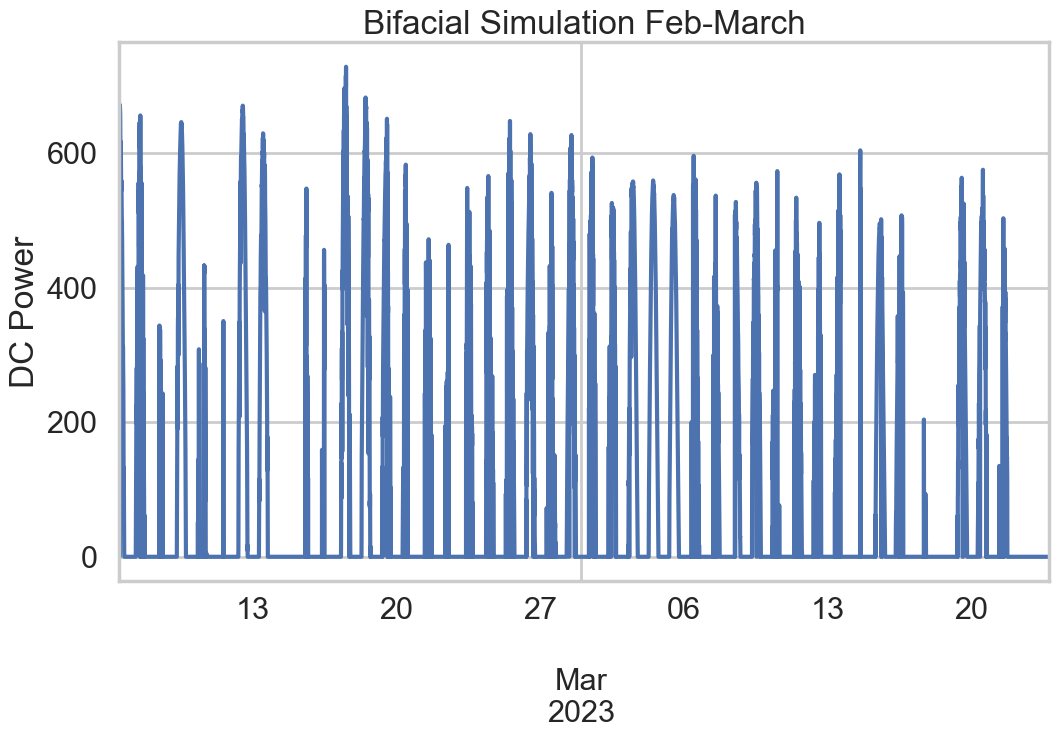

In [11]:
#Bifacial DC Power Feb-March
pdc = (411.6*2 )#two bifacial modules
pdc0= pdc#Nameplate DC Rating(BSTC from spec sheet)
gamma_pdc = -0.0036 #temp coeffiecient of power per degree C

pdc_bifi = pvsystem.pvwatts_dc(irrad['effective_irradiance'],
                               sapm_cellbifi,
                               pdc0,
                               gamma_pdc=gamma_pdc
                               ).fillna(0)

#pdc_bifi.plot(title='Bifacial Simulation Feb-March', ylabel='DC Power')
#pdc_bifi.to_csv('Modeled Power test.csv')

#pdc_bifi.to_csv('Modeled Power test2.csv')
       

pdc_bifi=pdc_bifi[(pdc_bifi.index.hour>=6)&(pdc_bifi.index.hour<=18)].copy()#removing night time values
pdc_bifi=pdc_bifi.replace(0, np.nan) #replace all 0 to nan to properly get the avvg in an hour
pdc_bifi_1= (pdc_bifi.resample('5Min').mean())
pdc_bifi_1=pdc_bifi_1.replace(np.nan, 0)#to get a better looking dataset
#pdc_bifi_1
pdc_bifi_1.plot(title='Bifacial Simulation Feb-March', ylabel='DC Power')
#pdc_bifi_1

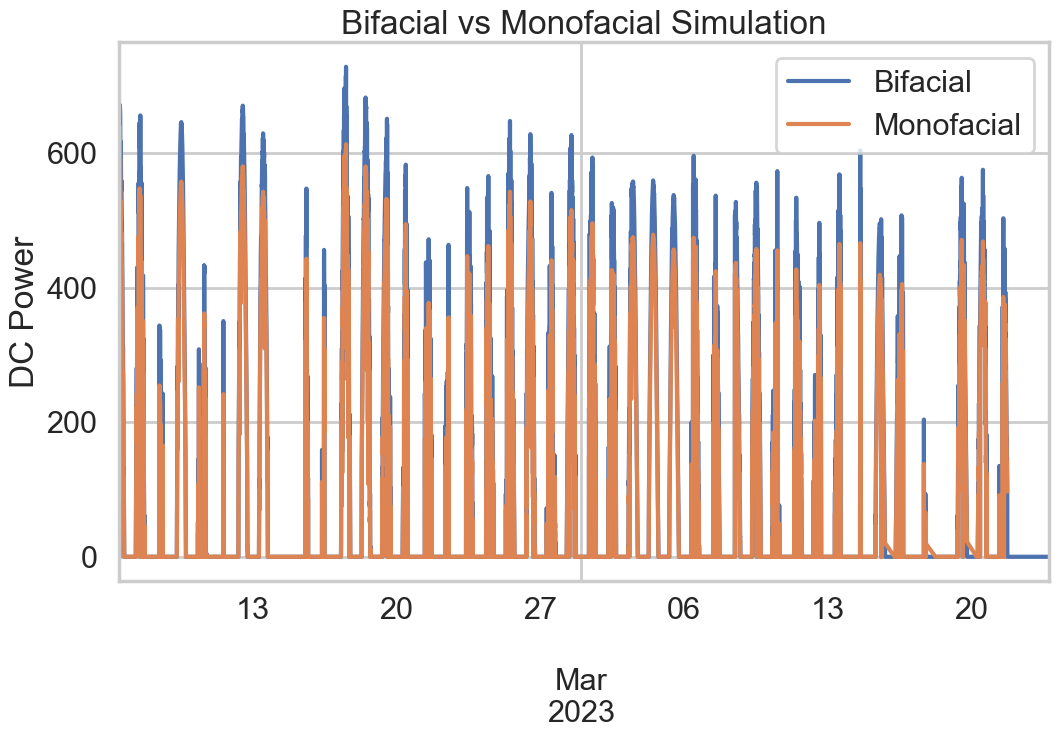

In [12]:
#Monofacial DC Power Feb-March
effective_irrad_mono = irrad['total_abs_front']
pdcm = 391.2*2 #two monofacial modules
pdc1= pdcm #Nameplate DC Rating(FSTC from spec sheet)
pdc_mono = pvsystem.pvwatts_dc(effective_irrad_mono,
                               sapm_cellmono,
                               pdc1,
                               gamma_pdc=gamma_pdc
                               ).fillna(0)

# plot monofacial results
plt.figure()
plt.title('Bifacial vs Monofacial Simulation')
pdc_bifi_1.plot(label='Bifacial')
pdc_mono.plot(label='Monofacial')
plt.ylabel('DC Power')
plt.legend()
# sphinx_gallery_thumbnail_number = 2
#df1.to_csv('All_Data.csv')
#pdc_mono

In [13]:
df1['Modeled_Monofacial']=pdc_mono
df1['Modeled_Bifacial']=pdc_bifi_1
#df1.to_csv('All Data_test2.csv')
#pdc_bifi_1
#df1

In [14]:
df1 = df1.replace(np.nan, 0)
df1.loc[df1['Modeled_Monofacial'] > df1['Monofacial'] , 'New_Model_Monofacial'] = df1['Monofacial']
df1.loc[df1['Modeled_Monofacial'] < df1['Monofacial'] , 'New_Model_Monofacial'] = df1['Modeled_Monofacial']

df1.loc[df1['Modeled_Bifacial'] > df1['Bifacial'] , 'New_Model_Bifacial'] = df1['Bifacial']
df1.loc[df1['Modeled_Bifacial'] < df1['Bifacial'] , 'New_Model_Bifacial'] = df1['Modeled_Bifacial']


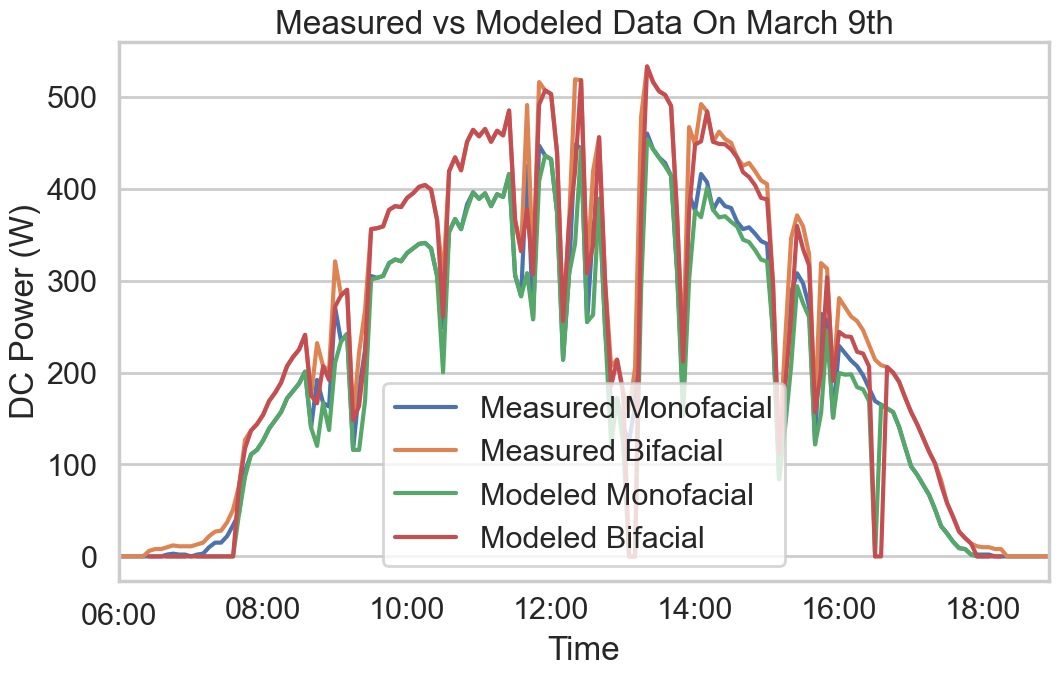

In [22]:
#lets try this for a clear day Feb12th

#Measured Data
df1_clearday=df1
df1_clearday=df1_clearday['2023-03-09 06:00':'2023-03-09 23:00 ']

#df1_hourly = (df1.resample('15Min').mean()) #resample date to hourly with the mean
#df1_hourly=df1_hourly['2023-02-27 06:00':'2023-02-27 23:00 ']
#Modeled Data
#pdc_bifi_clearday=pdc_bifi_1
#pdc_bifi_clearday=pdc_bifi_clearday['2023-02-09 06:00':'2023-02-09 23:00 ']

#pdc_mono_clearday=pdc_mono
#pdc_mono_clearday=pdc_mono_clearday['2023-02-09 06:00':'2023-02-09 23:00 ']

#Plot Front vs Back Irradiance On a clear day
plt.figure()
plt.title('Measured vs Modeled Data On March 9th')
df1_clearday['Monofacial'].plot(label='Measured Monofacial')
df1_clearday['Bifacial'].plot(label='Measured Bifacial')
df1_clearday['New_Model_Monofacial'].plot(label='Modeled Monofacial')
df1_clearday['New_Model_Bifacial'].plot(label='Modeled Bifacial')
plt.ylabel('DC Power (W)')
plt.xlabel('Time')
plt.legend()

print()


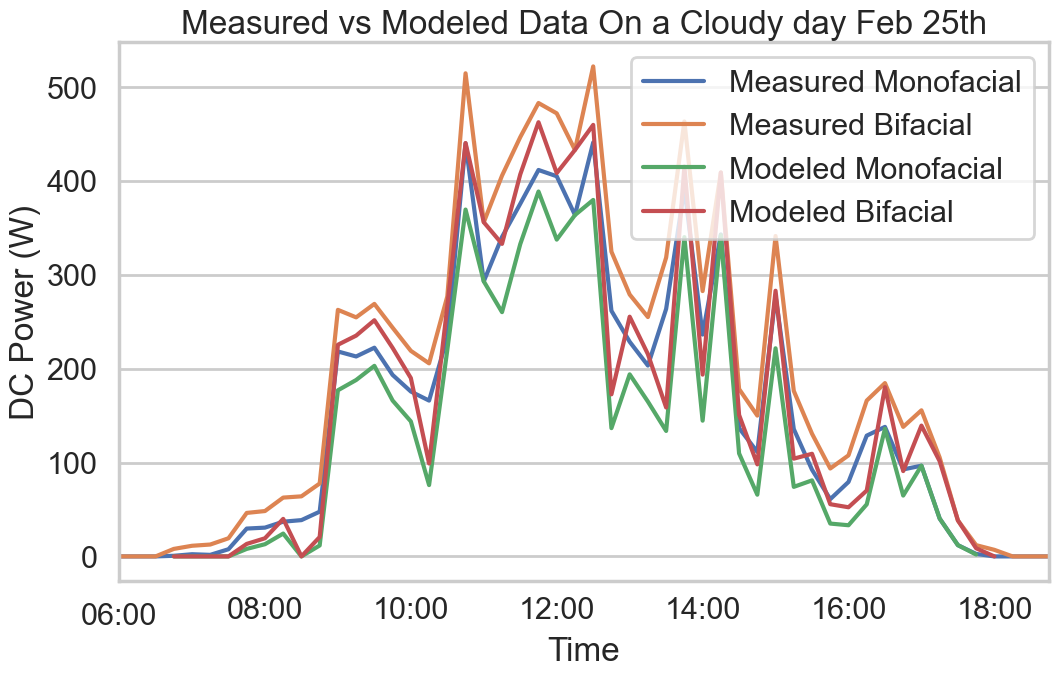

In [17]:
#Cloudy Data Feb 16th
#Measured Data
#lets try this for a clear day Feb12th

df1

#Measured Data
df1_cloudyday=df1
df1_cloudyday=df1_cloudyday['2023-02-25 06:00':'2023-02-25 23:00 ']
df1_hourly = (df1_cloudyday.resample('15Min').mean()) #resample date to hourly with the mean
#Plot Front vs Back Irradiance On a clear day
plt.figure()
plt.title('Measured vs Modeled Data On a Cloudy day Feb 25th')
df1_hourly['Monofacial'].plot(label='Measured Monofacial')
df1_hourly['Bifacial'].plot(label='Measured Bifacial')
df1_hourly['New_Model_Monofacial'].plot(label='Modeled Monofacial')
df1_hourly['New_Model_Bifacial'].plot(label='Modeled Bifacial')
plt.ylabel('DC Power (W)')
plt.xlabel('Time')
plt.legend()

print()

In [ ]:
#Cloudy Data Feb 16th
#Measured Data
#lets try this for a clear day Feb12th

df1

#Measured Data
df1_cloudyday=df1
df1_cloudyday=df1_cloudyday['2023-03-10 06:00':'2023-03-10 23:00 ']

#Plot Front vs Back Irradiance On a clear day
plt.figure()
plt.title('Measured vs Modeled Data On Cloudy day March 9th')
df1_cloudyday['Monofacial'].plot(label='Measured Monofacial')
df1_cloudyday['Bifacial'].plot(label='Measured Bifacial')
df1_cloudyday['Modeled_Monofacial'].plot(label='Modeled Monofacial')
df1_cloudyday['Modeled_Bifacial'].plot(label='Modeled Bifacial')
plt.ylabel('DC Power (W)')
plt.xlabel('Time')
plt.legend()

print()

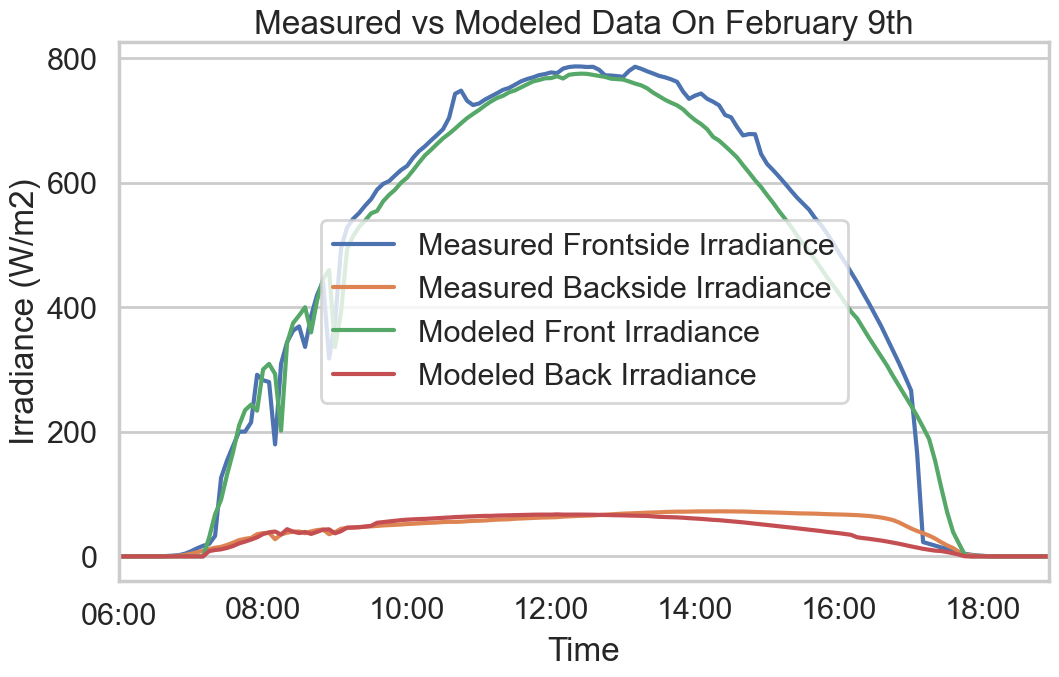

In [25]:
#Irradiance Comparism
#Measured Data
#lets try this for a clear day Feb12th

#Measured Data
df1_cloudyday=df1
df1_cloudyday=df1_cloudyday['2023-02-09 06:00':'2023-02-09 23:00 ']

#Plot Front vs Back Irradiance On a clear day
plt.figure()
plt.title('Measured vs Modeled Data On February 9th')
df1_cloudyday['RefCell02_Irr'].plot(label='Measured Frontside Irradiance')
df1_cloudyday['RefCell03_Irr'].plot(label='Measured Backside Irradiance')
df1_cloudyday['Modeled_Front_irradiance'].plot(label='Modeled Front Irradiance')
df1_cloudyday['Modeled_Back_irradiance'].plot(label='Modeled Back Irradiance')
plt.ylabel('Irradiance (W/m2)')
plt.xlabel('Time')
plt.legend()

print()

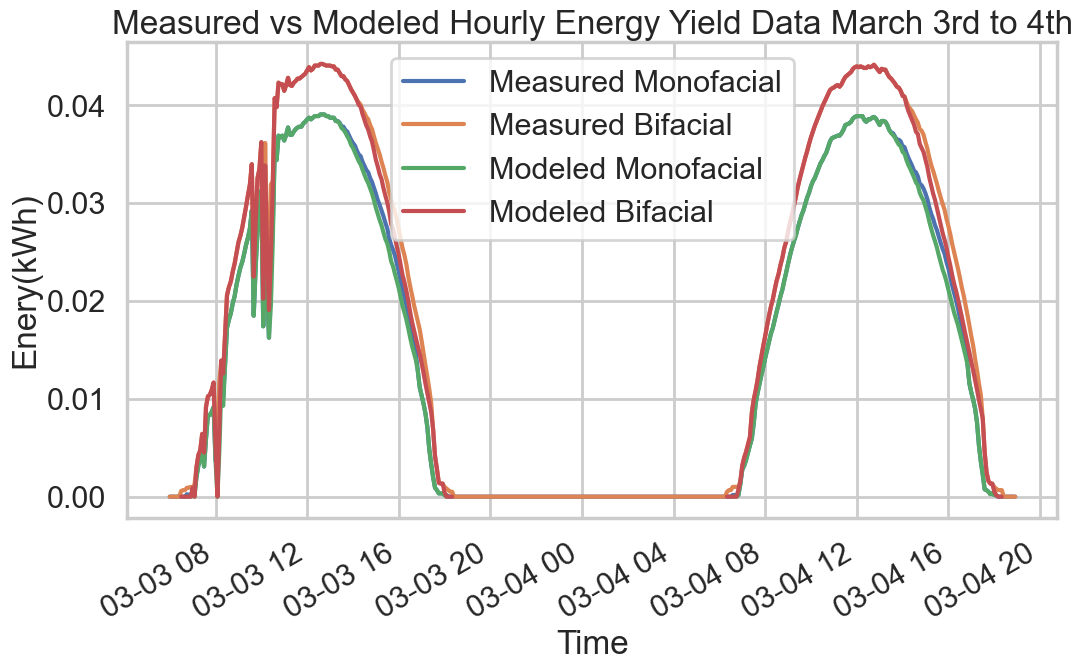

In [23]:
#Daily Energy Yield
df2=(df1*(5/60))/1000

#Measured Data
df2_cloudyday=df2
df2_cloudyday=df2_cloudyday['2023-03-03 06:00':'2023-03-04 23:00 ']

#Plot Front vs Back Irradiance On a clear day
plt.figure()
plt.title('Measured vs Modeled Hourly Energy Yield Data March 3rd to 4th')
df2_cloudyday['Monofacial'].plot(label='Measured Monofacial')
df2_cloudyday['Bifacial'].plot(label='Measured Bifacial')
df2_cloudyday['New_Model_Monofacial'].plot(label='Modeled Monofacial')
df2_cloudyday['New_Model_Bifacial'].plot(label='Modeled Bifacial')
plt.ylabel('Enery(kWh)')
plt.xlabel('Time')
plt.legend()

print()

In [24]:
df1.to_csv('Power_Analysis.csv')
df2.to_csv('EnergyYield_Analysis.csv')


# 

In [ ]:
df1 = df1.replace(np.nan, 0)
from sklearn.metrics import mean_squared_error
import math

#df1_clearday
#df1_cloudyday['Bifacial']
#pdc_bifi_cloudyday
#pdc_mono_cloudyday
y_actual_mono= df1_clearday['Monofacial'].dropna()
y_predicted_mono = df1_clearday['Modeled_Monofacial'].dropna()

y_actual_bifi = df1_clearday['Bifacial'].dropna()
y_predicted_bifi = df1_clearday['Modeled_Bifacial'].dropna()

MSE_mono = mean_squared_error(y_actual_mono, y_predicted_mono)
MSE_bifi = mean_squared_error(y_actual_bifi, y_predicted_bifi)

RMSE_mono = math.sqrt(MSE_mono)
RMSE_bifi = math.sqrt(MSE_bifi)
print("Root Mean Square Error:\n")
print(RMSE_mono)
print(RMSE_bifi)


In [ ]:
#MAPE Calculation
#df1 = df1.replace(np.nan, 0)
df1=df1[(df1.index.hour>=6)&(df1.index.hour<=18)].copy()#
df1_clearday=df1
df1_clearday=df1_clearday['2023-02-16 09:00':'2023-02-16 12:00 ']


df1_clearday=df1_clearday.replace(0,np.nan)
df1_clearday.loc[df1_clearday['Modeled_Monofacial'].isnull(), :] = np.nan
df1_clearday.loc[df1_clearday['Modeled_Bifacial'].isnull(), :] = np.nan

y_actual_mono= df1_clearday['Monofacial'].dropna()
y_predicted_mono = df1_clearday['Modeled_Monofacial'].dropna()

y_actual_bifi = df1_clearday['Bifacial'].dropna()
y_predicted_bifi = df1_clearday['Modeled_Bifacial'].dropna()

#def mean_absolute_percentage_error(y_actual_mono, y_predicted_mono): 
#    y_actual_mono, y_predicted_mono = np.array(y_actual_mono), np.array(y_predicted_mono)
 #   return np.mean(np.abs((y_actual_mono -y_predicted_mono) / y_true)) * 100
#mean_absolute_percentage_error
df1_clearday

In [ ]:
mape_mono=100 *abs(((y_predicted_mono - y_actual_mono))/y_actual_mono)
mape_bifi = 100 *abs(((y_predicted_bifi - y_actual_bifi))/y_actual_bifi)
mape_mono.mean()
mape_bifi.mean()

In [ ]:
mape.dropna().head(55)

In [ ]:
dfB1_clearday=dfB1
dfB1_clearday=dfB1_clearday['2023-02-12 01:00':'2023-02-12 23:00 ']

sapm_cellbifi_clearday=sapm_cellbifi
sapm_cellbifi_clearday=sapm_cellbifi_clearday['2023-02-12 01:00':'2023-02-12 23:00 ']
sapm_cellmono_clearday=sapm_cellmono
sapm_cellmono_clearday=sapm_cellmono_clearday['2023-02-12 01:00':'2023-02-12 23:00 ']
dfB1_clearday['ModeledBifacialCell_Temp']=sapm_cellbifi_clearday
dfB1_clearday['ModeledMonofacialCell_Temp']=sapm_cellmono_clearday

dfB1_clearday.to_csv('Modeled Temp test2.csv')


In [ ]:
#sapm_cellbifi.to_csv('Modeled Cell Temp bifi.csv')
#sapm_cellmono.to_csv('Modeled Cell Temp mono.csv')
#dfB1.to_csv('Measured Cell Temp .csv')